# Finite Element Analysis of a Concrete Dam under earthquake loading
### TODO completed by Joao Pedro REGAZZI FERREIRA DA SILVA

Filippo Gatti (filippo.gatti@centralesupelec.fr)

Frédéric Magoules (frederic.magoules@centralesupelec.fr)

### Set-up

Install `conda` environment: 
- `conda create --name st7 python=3.9 -y`

Activate `conda` environment:
- `conda activate st7`

Verify `conda`-wise `pip`install: 
- `which pip` `echo $CONDA_PREFIX`

Install `jupyter`: 
- `conda install -c anaconda jupyter`

Install packages:
- `conda install numpy`
- `conda install -c anaconda cython`
- `conda install -c conda-forge matplotlib`
- `conda install -c conda-forge scipy`
- `conda install nodejs`
- `conda install -c conda-forge pyvista`
- `pip install gmsh`
- `pip install mgmetis`

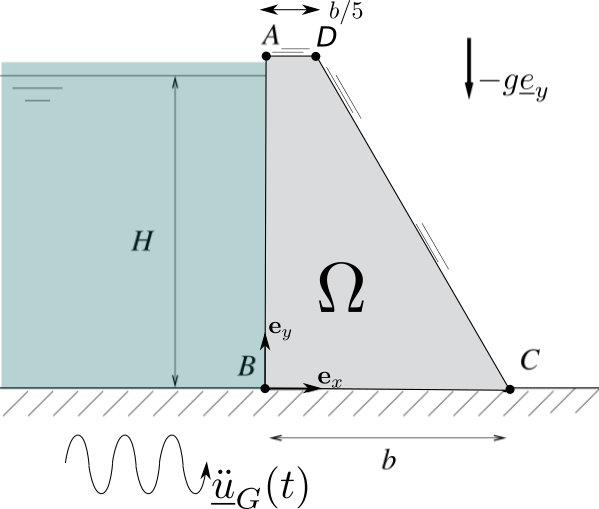

In [1]:
from IPython import display
display.Image("./dam_new.png")

In [2]:
%matplotlib inline
import sys

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.tri as tri
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.cm import coolwarm, magma

import numpy as np

# ! pip install pyvista # to install pyvista
import pyvista as pv

# Troubleshooting if installed with conda
#### Create the two following symbolic links

``sudo mkdir -p /usr/lib/dri``

``sudo ln -s /usr/lib/x86_64-linux-gnu/dri/swrast_dri.so /usr/lib/dri/``

``ln -sf /usr/lib/x86_64-linux-gnu/libstdc++.so.6.0.32 ~/.local/anaconda3/envs/st7/lib/python3.12/site-ackages/zmq/backend/cython/../../../../.././libstdc++.so.6``


__IMPORTANT__: activate the following line to display interactive images on `MyDocker`

In [3]:
# Activate if running on MyDocker
pv.start_xvfb()

In [4]:
# Set up images
pv.global_theme.background = 'lightgrey'
pv.global_theme.edge_color="black"
pv.global_theme.font.family="arial"
pv.global_theme.font.fmt="%.1f"
pv.global_theme.jupyter_backend="static"
pv.global_theme.font.label_size=30
pv.global_theme.font.color='black'
pv.global_theme.notebook=True
pv.global_theme.axes.show = True
pv.global_theme.window_size = [400, 500]

tol = 1e-6 # overall tolerance

---
---
## Problem set-up
---
---

### Trapezoidal cross section $\Omega\subset\mathbb{R}^{n_d}$:
- $n_d$ = 2
- height $H=30 m$ 
- base $b=10 m$  

In [5]:
ndim = 2  # dimension of the problem
b = 10.0 # base [m]
H = 30.0 # height [m]
xB = 0.0 # x-origin of the reference system (point B)
yB = 0.0 # y-origin of the reference system (point B)

In [6]:
# Create orthonormal basis (ex,ey,ez)
def GetOrthoBase() -> dict:
    """
    Define 3D orthonormal basis (x,y,z)
        
        Parameters:
        
        Returns: 
        
            Oxyz (dict): Dictionary of x, y, z unit norm vectors
    """
    Oxyz = {'x':np.array([1.,0.,0.],dtype=np.float64),
            'y':np.array([0.,1.,0.],dtype=np.float64),
            'z':np.array([0.,0.,1.],dtype=np.float64)}
    return Oxyz

### Linear isotropic elastic material (concrete):

- Mass density $\rho=2500 \:\rm kg.m^{-3}$
- Poisson's ratio $\nu=0.3$ ($-1\le \nu \le 0.5$)
- Young's modulus $E=10\:\rm GPa$

In [7]:
ρ = 2500.0 # Kg/m³
ν = 0.3
E = 10e+9 # Pa

Lamé parameters: 

$$\lambda=\frac{\nu E}{(1+\nu)(1-2\nu)}$$

$$\mu = \frac{E}{2(1+\nu)}$$

In [8]:
# Define material parameters
def GetLamePar(ρ: float, ν: float, E: float, element_label: dict) -> dict:
    """
    Define Lamé parameters for elastic homogeneous Constant Strain Triangle (CST) elements
    
        Parameters:
        
            ρ (float): unit-mass density [kg/m³]
            
            ν (float): Poisson's ratio [1]
            
            E (float): Young's modulus [Pa]
            
            element_label (dict): element type dictionary (only CST are available)
        
        Returns:
        
            LamePar (dict): Dictionary of Lamé parameters for each CST element
    """
    λ = E*ν/(1.-2.*ν)/(1.+ν) # Lambda parameter [Pa]
    μ = 0.5*E/(1.+ν)         # Shear modulus [Pa]
    assert element_label
    LamePar = {'λ':[λ for _ in range(len(element_label['CST']))],
               'μ':[μ for _ in range(len(element_label['CST']))],
               'ρ':[ρ for _ in range(len(element_label['CST']))]}
    return LamePar

---

### Loading and boundary/initial conditions

- Gravity force 

$$ \mathbf{f}_V(\mathbf{x},t) = - g \mathbf{e}_{y} \quad \forall (\mathbf{x},t)\in\Omega\times]0,T[$$

$g=9.81 m.s^{-2}$

In [9]:
g = 9.81 # gravity acceleration [m/s²]
fv = {'x':0.,'y':-g} # volume density force [N/m³]

- Hydrostatic pressure on the wall $\Gamma_{AB}$: 

$$\mathbf{f}_{S}(\mathbf{x},t)=\rho_w g (H-y)\mathbf{e}_{x}\quad \forall (\mathbf{x},t)\in\Gamma_{AB}\times]0,T[$$ 

$\rho_w=1000 kg.m^{-3}$, $\mathbf{n}(\mathbf{x})=-\mathbf{e}_x$

In [10]:
ρw = 1000. # water density Kg/m3
fs = {'x':lambda y: ρw*g*(H-y),
      'y':lambda y:0.} # surface density force along y

Try it yourself !


In [11]:
print(fs['x'](0.)) # @B
print(fs['x'](H))  # @A
print(fs['y'](0.))

294300.0
0.0
0.0


- Base $\Gamma_{BC}$ fixed to the ground which has a known acceleration 

$$t \to \mathbf{\ddot{u}}(\mathbf{x},t)= \mathbf{\ddot{u}}_G(t) \quad \forall (\mathbf{x},t)\in\Gamma_{BC}\times]0,T[$$

In [12]:
AG=  1. # Ground motion Amplitude [m/s/s]
f0 = 2 # dominant frequency of the motion [m/s/s]
oG= 2.*np.pi*f0 # Ground motion pulsation [rad/s]
aG = {'x':lambda t: np.kaiser(len(t),14)*AG * np.sin(oG*t),
      'y':lambda t: np.zeros_like(t)} # ground acceleration time history
nG = {'x':1.,'y':0.} # direction of the inertial forces

Plot the earthquake ground motion!

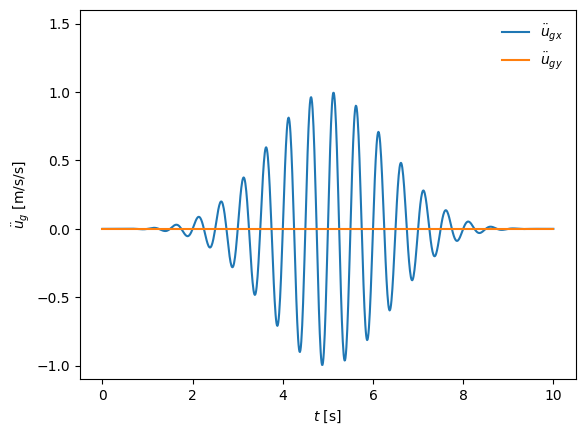

In [13]:
plt.ion()
plt.plot(np.linspace(0.0, 10.0, 1001, endpoint=True),
         aG['x'](np.linspace(0.0, 10.0, 1001, endpoint=True)),
        label=r'$\ddot{u}_{gx}$') # plot horizontal ground acceleration
plt.plot(np.linspace(0.0, 10.0, 1001, endpoint=True),
         aG['y'](np.linspace(0.0, 10.0, 1001, endpoint=True)),
        label=r'$\ddot{u}_{gy}$') # plot vertical ground acceleration
plt.xlabel(r'$t$ [s]') 
plt.ylabel(r'$\ddot{u}_g$ [m/s/s]')
plt.ylim(-AG*1.1,AG*1.6)
plt.legend(frameon=False, loc='upper right')
plt.ioff()

- Wall $\Gamma_{AD}\cup\Gamma_{DC}$ is traction-free: $$\mathbf{f}_{S}=\mathbf{0}$$

- Initial zero-displacement and zero-velocity state (at rest) : 

$$\mathbf{u}(\mathbf{x},0)=\mathbf{\dot{u}}(\mathbf{x},0)=\mathbf{0}, \forall \mathbf{x}\in\Omega$$

---
---
## Structural vibrations
---
---

### Total displacement field

$$\mathbf{u}(\mathbf{x},t) = \mathbf{\hat{u}}(\mathbf{x},t) + \mathbf{u}_G(t) \quad \forall (\mathbf{x},t)\in\Omega\times]0,T[$$

- $\mathbf{\hat{u}}(\mathbf{x},t)$: dynamic perturbation (vibration of the dam)
- $\mathbf{u}_G(t)$: incident wave motion (earthquake ground motion)

### Local conservation of linear momentum

- Cauchy's stress tensor $\sigma(\mathbf{x},t)$: it represents the local distribution of forces per unit surface within the continuum body

- Local conservation of linear momentum

$$\frac{d\mathbf{q}}{dt}=\mathbf{R}_{\text{ext}}\qquad \forall (\mathbf{x},t)\in\Omega\times ]0,T[$$

$$\text{div}_x(\sigma(\mathbf{u})) + \mathbf{f}_V=\rho\mathbf{\ddot{u}} \qquad \forall (\mathbf{x},t)\in\Omega\times ]0,T[$$

$$\sum_{j=1}^2 \frac{\partial\sigma_{ij}}{\partial x_j}(\mathbf{x},t)+f_{Vi}(\mathbf{x},t)=\rho \ddot{u}_i(\mathbf{x},t) \qquad \forall (\mathbf{x},t)\in\Omega\times]0,T[$$

with:

$$\sigma(\mathbf{u}).\mathbf{n}=\mathbf{f}_S \qquad \forall (\mathbf{x},t)\in\partial\Omega\times]0,T[ $$

with $\mathbf{n}$ the OUTWARD normal $\forall (\mathbf{x},t)\in\partial\Omega\times]0,T[ $



In Lagrangian framework and small-strain/small-displacement assumption.

$$\frac{d^2 \mathbf{u}}{d t^2} = \frac{\partial^2 \mathbf{u}}{\partial t^2}=\mathbf{\ddot{u}}$$ 


Moreover: 

$$\mathbf{\ddot{u}}(\mathbf{x},t)=\mathbf{\ddot{\hat{u}}}(\mathbf{x},t)+\mathbf{\ddot{u}}_G(t)$$

### Local conservation of angular momentum 

The Cauchy's stress tensor is symmetric:

$$\frac{d\mathbf{S}}{dt}=\mathbf{M}_{\text{ext}} \to\sigma = \sigma^T \qquad [\sigma]_{ij}=[\sigma]_{ji} \qquad \forall (\mathbf{x},t)\in\Omega\times]0,T[$$

---

### Strain : the symmetric part of the spatial gradient of the displacement field $\mathbf{u}$

$$\varepsilon(\mathbf{u}(\mathbf{x},t))=\varepsilon(\mathbf{\hat{u}}(\mathbf{x},t)))=\frac{1}{2}(\mathbf{\nabla}_x\otimes\mathbf{\hat{u}}+\mathbf{\hat{u}}\otimes\mathbf{\nabla}_x)\qquad \forall (\mathbf{x},t)\in\Omega\times]0,T[$$

$$[\varepsilon]_{ij}(\mathbf{u}(\mathbf{x},t))=\frac{1}{2}\left(\frac{\partial u_i}{\partial x_j}(\mathbf{x},t)+\frac{\partial u_j}{\partial x_i}(\mathbf{x},t)\right)\qquad \forall (\mathbf{x},t)\in\Omega\times]0,T[$$

The strain tensor is symmetric:
$$\varepsilon = \varepsilon^T$$

with :

- stretching of fiber $l_{e}\mathbf{e}$ :

$$\varepsilon_{ee} = \langle \varepsilon. \mathbf{e} , \mathbf{e} \rangle =\frac{\Delta l_e}{l_{e}}$$ 

- shearing of angle $\gamma_{12}$:

$$\varepsilon_{12} = \langle \varepsilon. \mathbf{e}_1 , \mathbf{e}_2 \rangle = \frac{\Delta \gamma_{12}}{2}$$

- volumetric strain :

$$\varepsilon_{\text{vol}}=\text{Tr}(\varepsilon) = \frac{\Delta V}{V}$$

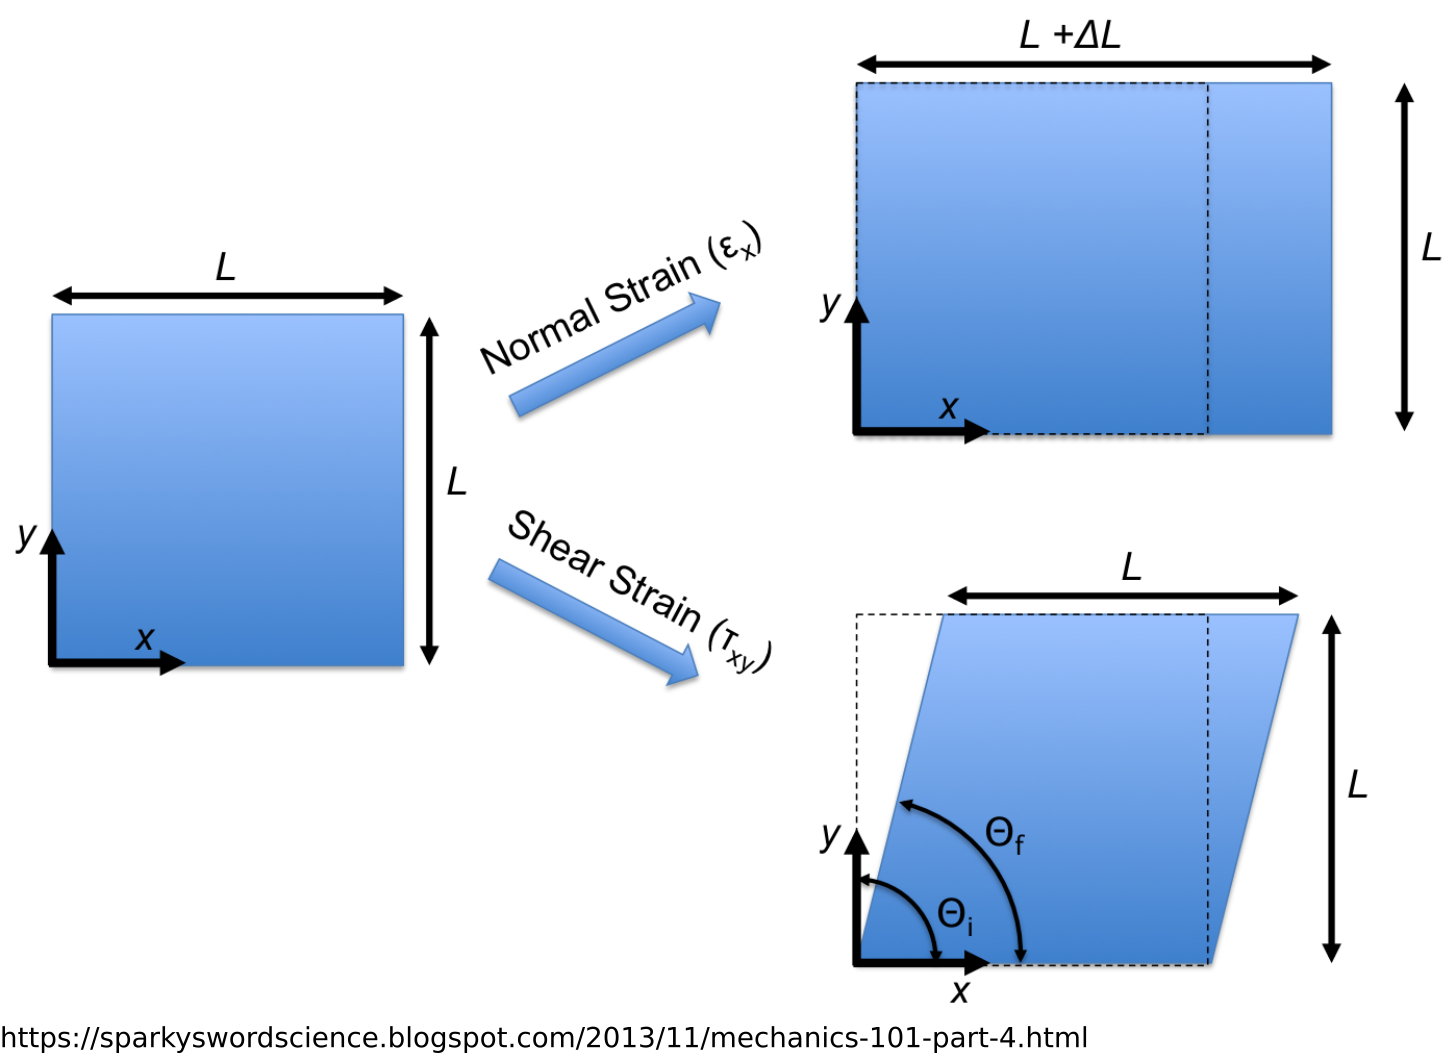

In [14]:
display.Image("./strain.png", width=500)

### Constitutive relationship between $\sigma$ and $\varepsilon$:
### Homogeneous Isotropic Linear Elasticity (HILE)

$$\sigma(\mathbf{u}(\mathbf{x},t))=\lambda(\mathbf{x}) \cdot \text{Tr}(\varepsilon(\mathbf{u}(\mathbf{x},t)))\mathbf{I}+2\mu(\mathbf{x}) \cdot\varepsilon(\mathbf{u}(\mathbf{x},t))=\mathbb{D}^{el}:\varepsilon(\mathbf{u}(\mathbf{x},t))$$

- identity matrices:

$$\mathbf{I} = \sum_{i}^{n_d} \mathbf{e}_i\otimes \mathbf{e}_i, \quad \mathbb{I} = \sum_{i,j}^{n_d,n_d} \mathbf{e}_i\otimes \mathbf{e}_j \otimes \mathbf{e}_i\otimes \mathbf{e}_j$$

$$[\mathbf{I}]_{ij}=\delta_{ij}$$

$$[\mathbb{I}]_{ijkl}=\delta_{ik}\delta_{jl}$$

Therefore, the components of the stress tensors, cast into a matrix, read:

$$[\sigma]_{ij}(\mathbf{u}(\mathbf{x},t)) = \lambda(\mathbf{x}) \cdot ([\varepsilon]_{kl}(\mathbf{u}(\mathbf{x},t))\cdot\delta_{kl})\cdot\delta_{ij}+2\mu(\mathbf{x}) \cdot [\varepsilon]_{ij}(\mathbf{u}(\mathbf{x},t))$$

- elastic stiffness matrix :

$$\mathbb{D}^{el}(\mathbf{x}) = \lambda(\mathbf{x})\cdot \mathbf{I}\otimes \mathbf{I}+2\mu(\mathbf{x})\cdot \mathbb{I}$$

$$[\mathbb{D}^{el}]_{ijkl}(\mathbf{x})=\lambda(\mathbf{x})\cdot\delta_{ij}\delta_{kl} +2\mu(\mathbf{x})\cdot\delta_{ik}\delta_{jl}$$

Note that $\mathbb{D}^{el}$ has the following symmetries:

$$[\mathbb{D}^{el}]_{ijkl}=[\mathbb{D}^{el}]_{jikl}=[\mathbb{D}^{el}]_{ijlk}=[\mathbb{D}^{el}]_{klij}$$

- double contraction:

$$\mathbb{D}^{el}:\varepsilon = \lambda\cdot \left(\mathbf{I}\otimes \mathbf{I}\right):\varepsilon+2\mu\cdot \mathbb:\varepsilon=\lambda\cdot\text{Tr}(\varepsilon)\cdot \mathbf{I} + 2\mu\cdot \varepsilon$$

The following property holds: $\mathbf{I}:\varepsilon=\text{Tr}(\mathbf{I}^T.\varepsilon)=\text{Tr}(\varepsilon^T.\mathbf{I})=\text{Tr}(\varepsilon)$

The earthquake ground motion is homogeneous and it does not change the stress state: 

$$[\sigma]_{ij}(\mathbf{u}(\mathbf{x},t)) = [\sigma]_{ij}(\mathbf{\hat{u}}(\mathbf{x},t)) $$

In [15]:
# Define Identity tensors
def GetIdentityTensors(ndim: int) -> tuple[float]: 
    """
    Get Identity tensors (2nd and 4th orders)
    
        Parameters:
        
            ndim (int): dimension of the problem (Ω ⊂ R^ndim)
        
        Returns:
        
            I2 (np.float64): 2nd order identity tensor: Id
            
            I2oI2 (np.float64): 4th order tensor product: Id otimes Id
            
            I4 (np.float64): 4th order identity tensor
    """
    I2 = np.identity(ndim)              # 2nd order identity tensor: Id
    I2oI2 = np.tensordot(I2,I2,axes=0)  # 4th order tensor product: Id otimes Id
    I4 = np.zeros((ndim,ndim,ndim,ndim)) # 4th order identity tensor
    for i in range(ndim):
        for j in range(ndim):
            I4[i,j,i,j] = 1.0 
    return I2, I2oI2, I4

Try it yourself!

- Define a $(2\times 2)$ tensor $\mathbf{A}$

In [16]:
# Define the matrix A
A = np.random.rand(2,2)
print(A)

[[0.67551012 0.16140707]
 [0.63764627 0.44945392]]


- Get the identity tensors $\mathbb{I}, \mathbf{I}\otimes\mathbf{I}, \mathbf{I}$

In [17]:
I2, I2oI2, I4 = GetIdentityTensors(ndim=2)

- Compute $\mathbf{B}=\mathbb{I}:\mathbf{A}$:

In [18]:
B = np.tensordot(I4,A,axes=2) # axes=2 stands for :
print(B) 

[[0.67551012 0.16140707]
 [0.63764627 0.44945392]]


- Verify that $\mathbb{I}:\mathbf{A}=\mathbf{A}$

In [19]:
print(np.isclose(B,A))

[[ True  True]
 [ True  True]]


- Compute $C=\mathbf{I}\otimes\mathbf{I}:\mathbf{A}$

In [20]:
C=np.tensordot(I2oI2,A,axes=2) # axes=2 stands for :
print(C)

[[1.12496404 0.        ]
 [0.         1.12496404]]


- Compute the $\text{Tr}(\mathbf{A})$

In [21]:
TrA = np.diag(A).sum()
print(TrA)

1.124964041445538


- Verify that $\mathbf{I}\otimes\mathbf{I}:\mathbf{A}=\text{Tr}(\mathbf{A})\mathbf{I}$

In [22]:
print(np.isclose(C,TrA*I2))

[[ True  True]
 [ True  True]]


---

---
---
## Weak formulation
---
---
Select a suitable space of _test functions_:

$$\mathbb{V}_0(\bar{\Omega}):=\left\lbrace \mathbf{w}(\mathbf{x}):\bar{\Omega}\to\mathbb{R}^2, \Vert\mathbf{w}\Vert_{\mathbb{V}_0(\bar{\Omega})}^2<+\infty, \mathbf{w}\vert_{\partial\Omega}=\mathbf{0}  \right\rbrace$$

with the norm $\Vert\mathbf{w}\Vert_{\mathbb{V}_0}^2$ defined as:

$$\Vert\mathbf{w}\Vert_{\mathbb{V}_0}^2=\int_{\Omega} (\boldsymbol{\nabla}_{\mathbf{x}}\otimes \mathbf{w}):\mathbb{D}_{el}:(\boldsymbol{\nabla}_{\mathbf{x}}\otimes \mathbf{w}) dv+\omega_{\text{ref}}^2\int_{\Omega}\rho\Vert\mathbf{w}\Vert^2 dv$$

This is the space of functions with _finite energy_: $\Vert\mathbf{w}\Vert_{\mathbb{V}_0}^2<+\infty$ 

### Weak formulation of Linear momentum conservation 

Multiply (scalar product) the equation

$$\text{div}_x(\sigma(\mathbf{u})) + \mathbf{f}_V=\rho\mathbf{\ddot{u}} \qquad \forall (\mathbf{x},t)\in\Omega\times ]0,T[$$

 by any $\mathbf{w}\in\mathbb{V}_0(\bar{\Omega})$ and integrate over $\Omega$ (but it can be integrated over open subdomain):

$$ \int_\Omega \langle \text{div}_x\mathbf{\sigma}(\mathbf{\hat{u}})(\mathbf{x},t), \mathbf{w}(\mathbf{x})\rangle dv + \int_\Omega \langle \mathbf{f}_V(\mathbf{x},t), \mathbf{w}(\mathbf{x})\rangle dv = \int_\Omega \langle \rho \frac{d^2 \mathbf{u}}{d t^2}(\mathbf{x},t), \mathbf{w}(\mathbf{x}) \rangle dv \quad  \forall \mathbf{w} \in \mathbb{V}_0(\bar{\Omega})$$

with the following integration by parts:

$$  \int_\Omega \langle \text{div}_x\sigma(\mathbf{\hat{u}}), \mathbf{w}\rangle dv =  \int_\Omega \text{div}_x(\sigma(\mathbf{\hat{u}}).\mathbf{w}) dv - \int_\Omega  \text{Tr}(\sigma(\mathbf{\hat{u}})^T.(\mathbf{\nabla}_x\otimes \mathbf{w})) dv$$

Apply divergence theorem:

$$\int_\Omega \text{div}_x(\sigma(\mathbf{\hat{u}}).\mathbf{w}) dv= \int_{\partial\Omega} \langle \sigma(\mathbf{\hat{u}}).\mathbf{n},\mathbf{w}\rangle ds$$

and retrieve the definition of strain tensor and the symmetry of $\sigma$ and $\varepsilon$:
$$\int_\Omega  \text{Tr}(\sigma(\mathbf{\hat{u}})^T.(\mathbf{\nabla}_x\otimes \mathbf{w}))=\int_\Omega  \text{Tr}(\sigma(\mathbf{\hat{u}}).\varepsilon(\mathbf{w})) dv = \int_\Omega \sigma(\mathbf{\hat{u}}):\varepsilon(\mathbf{w}) dv$$


The acceleration term in the weak formulation reads:

$$\int_\Omega \langle \rho \mathbf{\ddot{u}}(\mathbf{x},t), \mathbf{w}(\mathbf{x}) \rangle dv = \int_\Omega \langle \rho \mathbf{\ddot{\hat{u}}}(\mathbf{x},t), \mathbf{w}(\mathbf{x}) \rangle dv + \int_\Omega \langle \rho \mathbf{\ddot{u}}_G(t), \mathbf{w}(\mathbf{x}) \rangle dv  \quad  \forall \mathbf{w} \in \mathbb{V}_0(\bar{\Omega})$$

#### Mass bilinear form 

$$\mathcal{M}(\mathbf{\ddot{\hat{u}}},\mathbf{w}) = \int_\Omega \rho \langle \mathbf{\ddot{\hat{u}}} (\mathbf{x},t) , \mathbf{w}(\mathbf{x}) \rangle dv $$

#### Stiffness bilinear form 

$$\mathcal{K}(\mathbf{\hat{u}},\mathbf{w}) = \int_\Omega \sigma(\mathbf{\hat{u}}):\varepsilon(\mathbf{w}) dv = \int_\Omega  \lambda \cdot \text{Tr}(\varepsilon(\mathbf{\hat{u}}))\cdot\text{Tr}(\varepsilon(\mathbf{w})) dv + \int_\Omega 2 \mu \cdot \varepsilon(\mathbf{\hat{u}}):\varepsilon(\mathbf{w}) dv $$

with $$\text{Tr}(\varepsilon(\mathbf{w}))=\text{Tr}(\boldsymbol{\nabla}_x\otimes\mathbf{w}(\mathbf{x})) = \langle\boldsymbol{\nabla}_x,\mathbf{w}(\mathbf{x})\rangle = \text{div}_x(\mathbf{w}(\mathbf{x}))$$

To simplify the computation of $\mathcal{K}(\mathbf{\hat{u}},\mathbf{w})$, given the symmetry of $\mathbb{D}_{el}$ and $\varepsilon$ one cas observe that:

$$\sigma(\mathbf{u}):\varepsilon(\mathbf{w})=\varepsilon(\mathbf{u}):\mathbb{D}_{el}:\varepsilon(\mathbf{w})=\sum_{i,j,k,l=1}^{n_d} D_{ijkl}\varepsilon_{ij}(\mathbf{u})\varepsilon_{kl}(\mathbf{w})=\sum_{i,j,k,l=1}^{n_d} D_{ijkl}\frac{\partial u_i}{\partial x_j}\frac{\partial w_k}{\partial x_l}=\left(\mathbf{w}\otimes\boldsymbol{\nabla}_\mathbf{x}\right):\mathbb{D}_{el}:\left(\boldsymbol{\nabla}_\mathbf{x}\otimes\mathbf{u} \right)$$

#### External forces linear functional

$$ \mathcal{F}(\mathbf{w}) = \underbrace{\int_\Omega \langle \mathbf{f}_V(\mathbf{x},t), \mathbf{w}(\mathbf{x})\rangle dv}_{\text{volume forces}} -\underbrace{ \int_\Omega \rho \langle \mathbf{\ddot{u}}_G (\mathbf{x},t) , \mathbf{w}(\mathbf{x}) \rangle dv}_{\text{inertial forces}} + \underbrace{\int_{\partial\Omega} \langle \sigma(\mathbf{u}(\mathbf{x},t)).\mathbf{n}(\mathbf{x}),\mathbf{w}(\mathbf{x})\rangle ds}_{\text{surface loading}} $$

Applying boundary conditions on $\partial \Omega$ and considering the constitutive relationship (HILE), the weak formulation can be written as:


$$\mathcal{M}(\mathbf{\ddot{\hat{u}}},\mathbf{w}) + \mathcal{K}(\mathbf{\hat{u}},\mathbf{w}) = \mathcal{F}(\mathbf{w})\qquad\forall\mathbf{w}\in \mathbb{V}_0(\bar{\Omega})$$

---
---
## The Galerkin Finite Element method
---
---

The Finite Element method approximates the dynamic equation:

$$\mathcal{M}(\mathbf{\ddot{\hat{u}}},\mathbf{w}) + \mathcal{K}(\mathbf{\hat{u}},\mathbf{w}) = \mathcal{F}(\mathbf{w}) \qquad\forall\mathbf{w}\in \mathbb{V}_0(\bar{\Omega})$$

by searching for an approximate solution $\mathbf{\hat{u}}_h$ defined over the space of $p^{\text{th}}$-order piece-wise polynomials.

The domain $\Omega$ is discretized by a non-overlapping set of triangles, a mesh. The collection of _finite elements_ is called triangulation $\mathcal{T}=\left\lbrace \Omega_e\right\rbrace_{e=1}^{N_e}$ (checkout the notebook `DamFEA_mesher.ipynb`)

<img src="triangular_shape_functions.png">

The geometry of each triangle $\bar{\Omega}_e\in\mathcal{T}$ is approximated with shape functions $N_{i}(\boldsymbol{\xi}):\bar{\Omega}_{\triangle}\to \bar{\Omega}_e$ with $\bar{\Omega}_{\triangle}$ being the _master element_ defined over the unit triangle in $(\xi,\eta)$ with 3 nodes (1,2,3)


$$x_h = \sum_{i=1}^{N^e_n} N_{x,i}\left(\boldsymbol{\xi}\right)X_i \qquad y_h = \sum_{i=1}^{N^e_n} N_{y,i}\left(\boldsymbol{\xi}\right)Y_i$$

with $N_n^e=3$ being the number of nodes per element $e$. 
The pedex $h$ indicates the characteristic size of the mesh $$h=\max_{e\in\mathcal{T}}\vert\Omega_e\vert$$

One can collect the nodal shape functions in two vectors:

$$\mathbf{N}_x=\begin{bmatrix}N_{x1} \\ ... \\ N_{xn}\end{bmatrix}=\begin{bmatrix}N_{x1} \\ N_{x2} \\ N_{x3}\end{bmatrix} \qquad \mathbf{N}_y=\begin{bmatrix}N_{y1} \\ ... \\ N_{yn}\end{bmatrix}=\begin{bmatrix}N_{y1} \\ N_{y2} \\ N_{y3}\end{bmatrix}$$

$$x_h = \mathbf{N}^{T}_x(\boldsymbol{\xi}).\mathbf{C}_x\qquad y_h = \mathbf{N}^{T}_y(\boldsymbol{\xi}).\mathbf{C}_y \qquad \mathbf{C}_x=\begin{bmatrix}X_1 \\ ... \\ X_n\end{bmatrix}=\begin{bmatrix}X_{1} \\ X_{2} \\ X_{3}\end{bmatrix} \qquad \mathbf{C}_y=\begin{bmatrix}Y_1\\...\\Y_n\end{bmatrix}=\begin{bmatrix}Y_{1} \\ Y_{2} \\ Y_{3}\end{bmatrix}$$


$$\mathbf{x}\approx\begin{bmatrix} x_h\\ y_h\end{bmatrix} = \mathbb{N}_{\mathbf{x}}(\boldsymbol{\xi}).\mathbf{X} = \begin{bmatrix} \mathbf{N}^{T}_x(\boldsymbol{\xi}) & \mathbf{0} \\ \mathbf{0} & \mathbf{N}^{T}_y(\boldsymbol{\xi}) \end{bmatrix}.\begin{bmatrix} \mathbf{C}_x \\ \mathbf{C}_y\end{bmatrix} $$

The _iso-parametric_ Finite Element method employs the same discretization for $\mathbf{x}$ and $\mathbf{u}$:

$$\hat{u}_{h,x} = \sum_{i=1}^{N^e_n} N_{u_x,i}\left(\mathbf{x}_h(\boldsymbol{\xi})\right)u_{x,i} \qquad \hat{u}_{h,y} = \sum_{i=1}^{N^e_n} N_{u_y,i}\left(\mathbf{x}_h(\boldsymbol{\xi})\right)u_{y,i}$$


$$\mathbf{\hat{u}}_h\left(\mathbf{x},t\right)=\begin{bmatrix} \hat{u}_x(\mathbf{x}_h,t)\\ \hat{u}_y(\mathbf{x}_h,t)\end{bmatrix}= \begin{bmatrix} \mathbf{N}^{T}_{u_x}\left(\mathbf{x}_h(\boldsymbol{\xi})\right) & \mathbf{0} \\ \mathbf{0} & \mathbf{N}^{T}_{u_y}\left(\mathbf{x}_h(\boldsymbol{\xi})\right) \end{bmatrix}.\begin{bmatrix} \mathbf{\hat{U}}_x(t) \\ \mathbf{\hat{U}}_y(t)\end{bmatrix}=\mathbb{N}_{\mathbf{u}}\left(\mathbf{x}_h(\boldsymbol{\xi})\right).\mathbf{\hat{U}}(t) $$

- In general and in the following, $\mathbf{N}_\mathbf{x}=\mathbf{N}_\mathbf{y}=\mathbf{N}_{u_x}=\mathbf{N}_{u_y}=\mathbf{N}$ et $\mathbb{N}_\mathbf{x}=\mathbb{N}_\mathbf{u}$.

- Moreover, $N_i\in\mathbb{P}^p(\bar{\Omega}_\triangle)$ (p$^{\text{th}}$ order polynomials).


- The mentioned polynomial interpolation is valid $\forall \mathbf{x}\in\bar{\Omega}_e$. 

- The interpolation over the whole domain $\Omega$ is a piece-wise polynomial interpolation.

First, start by getting the nodal coordinates

In [23]:
# Get coordinates of nodes within an element
def GetElemNodeCoord(node_xyz: list[list[int]],e_ijk: list[int]) -> tuple[float]:
    """
    Get i,j,k nodal coordinates X,Y,Z associated to element node of element e
        
    Z_i=Z_j=Z_k=0.0 if ndim=2
        
        Parameters:
        
            node_xyz (list(list(int))): list of nodal coordinates (x_i,x_j,x_k) 
                per each element e
        
            e_ijk (list(int)): global indices of (i,j,k) nodes for each element e
        
        Returns:
            (X_i,X_j,X_k) (np.array(np.float64)): tuple of array of (i,j,k) coordinates, 
                with X_i = np.array([x_i,y_i])
    """
    (X_i,X_j,X_k) = [np.array(a) for a in node_xyz[e_ijk]]
    return (X_i,X_j,X_k)

In order to define the unique Degree of Freedom (DOF), it is necessary to scatter the nodes variables according to different layouts:

- 'xxyy':

$$\mathbf{U}_e(t)=\begin{bmatrix} u_{h,x}(\mathbf{x}_i,t) \\ u_{h,x}(\mathbf{x}_j,t) \\ u_{h,x}(\mathbf{x}_k,t)\\ u_{h,y}(\mathbf{x}_i,t) \\ u_{h,y}(\mathbf{x}_j,t) \\ u_{h,y}(\mathbf{x}_k,t)\end{bmatrix}$$

- 'xyxy'

$$\mathbf{U}_e(t)=\begin{bmatrix} u_{h,x}(\mathbf{x}_i,t) \\u_{h,y}(\mathbf{x}_i,t) \\ u_{h,x}(\mathbf{x}_j,t) \\ u_{h,y}(\mathbf{x}_j,t) \\ u_{h,x}(\mathbf{x}_k,t)\\u_{h,y}(\mathbf{x}_k,t)\end{bmatrix}$$

In [24]:
# Scatter nodal dof to global dof according to different styles
def ScatterNode2Dof(node: int,
                    dim: int,
                    n_nodes: int,
                    ndim=2,
                    style="xxyyzz") -> int:
    """
    Scatter (node,dim) into a global scalar dof according to the style
       
       Parameters:
       
           node (int): current node index
       
           dim (int): current dimension (in range 0:ndim-1)
       
           n_nodes (int): total number of nodes
       
           ndim (int): dimension of the problem (Ω ⊂ R^ndim)
       
           style (str): two options are available:
                1. style="xxyy" ("xxyyzz") : 
                    [u_(1,x),u_(2,x),...,u_(n_nodes,x),u_(1,y),u_(2,y),...,u_(n_nodes,y)]
                
                2. style="xyxy" ("xyzxyz") : 
                    [u_(1,x),u_(1,y),u_(2,x),u_(2,y),...,u_(n_nodes,x),u_(n_nodes,y)]
    
        Returns:
        
            dof (list(int)): list of dofs reordered according to style
    """
    
    n2d = {'x':0,'y':1,'z':2}
    dim = n2d[dim]
    
    if "xxyy" in style:
        dof = n_nodes*dim + node
        
    elif "xyxy" in style:
        dof = ndim*node + dim
        
    return dof

Compute 2D shape functions $\mathbf{N}(x_h(\xi,\eta),y_h(\xi,\eta))$ as _area coordinates_ [Mobius, 1827]:

$$N_i(\xi,\eta)=\frac{\text{area sub-triangle i}}{\text{area triangle}}=\frac{L_i}{L} = \frac{(x-x_k)\cdot(y_j-y_k)-(x_j-x_k)\cdot(y-y_k)}{(x_i-x_k)\cdot(y_j-y_k)-(x_j-x_k)\cdot(y_i-y_k)}$$

$$=1-\frac{(y_k-y_j)\cdot(x_j-x_i)}{L}\cdot\xi-\frac{(x_j-x_k)\cdot(y_k-y_i)}{L}\cdot\eta=1-a\cdot\xi-b\cdot\eta$$


$$N_j(\xi,\eta)=\frac{\text{area sub-triangle j}}{\text{area triangle}}=\frac{L_j}{L} = \frac{(x-x_i)\cdot(y_k-y_i)-(x_k-x_i)\cdot(y-y_i)}{(x_j-x_i)\cdot(y_k-y_i)-(x_k-x_i)\cdot(y_j-y_i)}$$

$$=\frac{(y_k-y_i)\cdot(x_j-x_i)}{L}\cdot\xi-\frac{(x_k-x_i)\cdot(y_k-y_i)}{L}\cdot\eta=c\cdot\xi+d\cdot\eta$$


$$N_k(\xi,\eta)=\frac{\text{area sub-triangle k}}{\text{area triangle}}=\frac{L_k}{L} = \frac{(x-x_i)\cdot(y_k-y_i)-(x_k-x_i)\cdot(y-y_i)}{(x_j-x_i)\cdot(y_k-y_i)-(x_k-x_i)\cdot(y_j-y_i)}$$

$$=-\frac{(y_j-y_i)\cdot(x_j-x_i)}{L}\cdot\xi+\frac{(x_j-x_i)\cdot(y_k-y_i)}{L}\cdot\eta=e\cdot\xi+f\cdot\eta$$


with $\xi=\frac{x-x_i}{x_j-x_i}$ and $\eta=\frac{y-y_i}{y_k-y_i}$. $N_j$ and $N_k$ are obtained by permuting the indexes counter-clockwise.


In a more compact way, the shape functions can be defined as:

$$N_i = \frac{L_i}{L}=\frac{\langle \mathbf{x}-\mathbf{x}_k,(\mathbf{x}_j-\mathbf{x}_k)\wedge\mathbf{i}_z \rangle}{\langle \mathbf{x}_i-\mathbf{x}_k, (\mathbf{x}_j-\mathbf{x}_k)\wedge\mathbf{i}_z \rangle}$$

$N_j$ and $N_k$ are obtained by permuting the indexes counter-clockwise.

![triangular_shape_functions_unity.png](triangular_shape_functions_unity.png)

In [25]:
# Compute shape functions for CST (Mobius area coordinates)
def ComputeShapeFunctions(x,node_xyz,e_ijk,e_type="CST",ndim=2):
    """
    Compute shape functions N for element with i,j,k nodes
    
        Parameters:
        
            x (np.array(dtype=np.float64): array of coordinates (x,y,z)
        
            node_xyz (list(list(int))): list of nodal coordinates (x_i,x_j,x_k) 
                per each element e
        
            e_ijk (list(int)): global indices of (i,j,k) nodes for each element e
        
            e_type (str): type of elemnt (CST only available)
        
            ndim (int): dimension of the problem (Ω ⊂ R^ndim)
        
        Returns:
        
            N (np.float64): Shape function vector defined as:
                
                N = [Li(x,y)/L, Lj(x,y)/L, Lk(x,y)/L]
    """
    
    if "CST" in e_type.upper():
        # baricentric or area coordinates [Mobius, 1827]
        (x_i,x_j,x_k) = GetElemNodeCoord(node_xyz,e_ijk) # nodal coordinates
        Li = np.linalg.det(np.vstack((x  -x_k, x_j-x_k, GetOrthoBase()['z']))) # 2*Area of triangle i
        Lj = np.linalg.det(np.vstack((x  -x_i, x_k-x_i, GetOrthoBase()['z']))) # 2*Area of triangle j
        Lk = np.linalg.det(np.vstack((x  -x_j, x_i-x_j, GetOrthoBase()['z']))) # 2*Area of triangle k
        L  = np.linalg.det(np.vstack((x_i-x_k, x_j-x_k, GetOrthoBase()['z']))) # 2*Area of the triangle
        N = np.array((Li/L,Lj/L,Lk/L),dtype=np.float64)
    return N

Try it yourself!

- Parse the mesh:

In [26]:
mesh = pv.read('DamMesh.msh')
# Mesh nodes
n_nodes = mesh.n_points # number of nodes on the mesh
ndofs = ndim*n_nodes # number of degrees of freedom
node_xyz = mesh.points.astype(np.float64) # np.array
# Cell tags (from gmsh)
# 3: 2D lines
# 5: 2D triangles
cell_tag = {3:"LIN",5:"CST"}
cell_physical_labels = {cell_tag[k]:v for k,v in mesh.cells_dict.items()}
    
# pg = mesh.cell_arrays["gmsh:physical"] # get physical surface (the mesh of Ω domain)
pg = mesh.cell_data["gmsh:physical"]  # get physical surface (the mesh of Ω domain)

connectivity_dict = {}
c = 0
for k,v in mesh.cells_dict.items():
    connectivity_dict[cell_tag[k]] = [[e,pg[e]] for e in range(c,c+v.shape[0])]
    c += v.shape[0]

 - Check the areas of the mesh CST triangles:

In [27]:
# Check the area of the triangles
for e_ijk in cell_physical_labels["CST"]:
    (x_i,x_j,x_k) = GetElemNodeCoord(node_xyz,e_ijk) # nodal coordinates
    L  = np.linalg.det(np.vstack((x_i-x_k, x_j-x_k, GetOrthoBase()['z']))) # 2*Area of the triangle
    print(L)

3.7500000000250675
7.500000000030249
3.7500000000245146
7.500000000032913
3.749999999983316
7.500000000014648
3.7500000000035705
7.500000000029779
7.499999999955195
11.249999999941288
7.499999999976588
11.249999999965883
7.499999999977048
11.24999999998928
7.50000000001092
11.250000000018032
11.250000000035149
14.999999999991587
11.250000000014944
14.999999999974587
11.249999999993511
14.99999999997608
11.249999999977435
14.999999999954897
15.000000000018591
18.749999999996934
15.000000000012383
18.749999999993936
15.000000000024666
18.750000000029143
15.000000000014255
18.750000000013628


- Compute $\mathbf{N}(\mathbf{x}_g)$ for all points $\mathbf{x}_g$ in the grid

In [28]:
# Test the values of the shape functions
N = lambda X,e_ijk: ComputeShapeFunctions(X,node_xyz,e_ijk,e_type="CST",ndim=ndim)

for e_ijk in cell_physical_labels["CST"]:
    print(e_ijk)
    N_xg = np.vstack([N(x,e_ijk) for x in node_xyz[e_ijk]]) # evaluate N on the previously define grid
    Ni = N_xg[:,0].reshape(3,) # i^th shape function  
    Nj = N_xg[:,1].reshape(3,) # j^th shape function 
    Nk = N_xg[:,2].reshape(3,) # k^th shape function 
    print("Ni",Ni,"Nj",Nj,"Nk",Nk) # it must return 1 0 0, 0 1 0, 0 0 1.

[ 0  4 15]
Ni [1. 0. 0.] Nj [0. 1. 0.] Nk [0. 0. 1.]
[15  4 16]
Ni [1. 0. 0.] Nj [0. 1. 0.] Nk [0. 0. 1.]
[15 16 14]
Ni [1. 0. 0.] Nj [0. 1. 0.] Nk [0. 0. 1.]
[14 16 17]
Ni [1. 0. 0.] Nj [0. 1. 0.] Nk [0. 0. 1.]
[14 17 13]
Ni [1. 0. 0.] Nj [0. 1. 0.] Nk [0. 0. 1.]
[13 17 18]
Ni [1. 0. 0.] Nj [0. 1. 0.] Nk [0. 0. 1.]
[13 18  3]
Ni [1. 0. 0.] Nj [0. 1. 0.] Nk [0. 0. 1.]
[ 3 18 12]
Ni [1. 0. 0.] Nj [0. 1. 0.] Nk [0. 0. 1.]
[ 4  5 16]
Ni [1. 0. 0.] Nj [0. 1. 0.] Nk [0. 0. 1.]
[16  5 19]
Ni [1. 0. 0.] Nj [0. 1. 0.] Nk [0. 0. 1.]
[16 19 17]
Ni [1. 0. 0.] Nj [0. 1. 0.] Nk [0. 0. 1.]
[17 19 20]
Ni [1. 0. 0.] Nj [0. 1. 0.] Nk [0. 0. 1.]
[17 20 18]
Ni [1.00000000e+00 2.61901821e-29 0.00000000e+00] Nj [0. 1. 0.] Nk [0. 0. 1.]
[18 20 21]
Ni [1. 0. 0.] Nj [0. 1. 0.] Nk [1.74601214e-29 0.00000000e+00 1.00000000e+00]
[18 21 12]
Ni [1. 0. 0.] Nj [0. 1. 0.] Nk [0. 0. 1.]
[12 21 11]
Ni [1. 0. 0.] Nj [0. 1. 0.] Nk [0. 0. 1.]
[ 5  6 19]
Ni [1. 0. 0.] Nj [0. 1. 0.] Nk [0. 0. 1.]
[19  6 22]
Ni [1. 0. 0.] Nj

- Pick one element

In [29]:
# Loop over elements
e_ijk = cell_physical_labels["CST"][1] # first element
print(e_ijk)  # print node labels

[15  4 16]


- Compute the grid at different locations

In [30]:
Cmin_e = np.min(node_xyz[e_ijk],axis=0) # get minimum coordinates along x,y,z
Cmax_e = np.max(node_xyz[e_ijk],axis=0) # get maximum coordinates along x,y,z
xmin_e = Cmin_e[0] # x-min over element e
ymin_e = Cmin_e[1] # y-min over element e
xmax_e = Cmax_e[0] # x-max over element e
ymax_e = Cmax_e[1] # y-max over element e
x1Dg = np.linspace(xmin_e,xmax_e,10,endpoint=True) # create a x-grid of 10 points
y1Dg = np.linspace(ymin_e,ymax_e,10,endpoint=True) # create a y-grid of 10 points
z1Dg = np.array([0.0]) # create 2D grid (1 point only on z direction)
y3Dg,x3Dg,z3Dg = np.meshgrid(y1Dg,x1Dg,z1Dg) # create 3D meshgrid of points
xg = np.vstack([x3Dg.flatten(),y3Dg.flatten(),z3Dg.flatten()]).T # group into a flattened vector

In [31]:
# Define lambda function to evaluate N on the generic X point
N = lambda X: ComputeShapeFunctions(X,node_xyz,e_ijk,e_type="CST",ndim=ndim)

N_xg = np.vstack([N(x) for x in xg]) # evaluate N on the previously define grid
Ni = N_xg[:,0].reshape(x3Dg.squeeze().shape) # i^th shape function  
Nj = N_xg[:,1].reshape(x3Dg.squeeze().shape) # j^th shape function 
Nk = N_xg[:,2].reshape(x3Dg.squeeze().shape) # k^th shape function 
# ax.set_aspect('equal', adjustable='box')

- Plot $N_i(x,y)$:

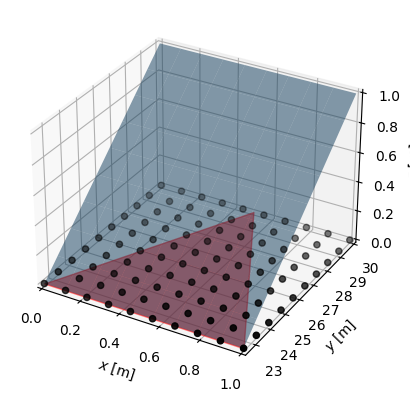

In [32]:
plt.ion()
ax = plt.axes(projection='3d')
ax.add_collection3d(Poly3DCollection([node_xyz[e_ijk]],alpha=0.5,color='red'))
ax.scatter(x3Dg,y3Dg,color='black')
ax.plot_surface(x3Dg.squeeze(),y3Dg.squeeze(),Ni,alpha=0.5,
                label=r"$N_i(x,y)$")
ax.set(xlim=(xmin_e,xmax_e),ylim=(ymin_e,ymax_e),zlim=(0.0,1.0))
ax.set(xlabel=r"$x$ [m]",ylabel=r"$y$ [m]",zlabel=r"$z$ [m]")
plt.show()
plt.ioff()

- Plot $N_j(x,y)$

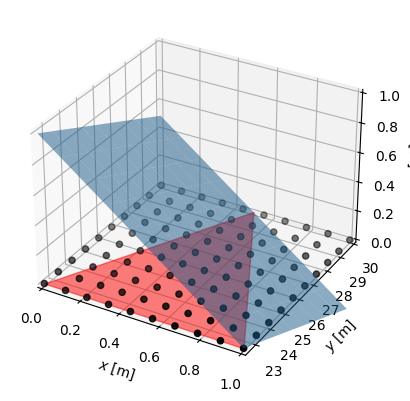

In [33]:
plt.ion()
ax = plt.axes(projection='3d')
ax.add_collection3d(Poly3DCollection([node_xyz[e_ijk]],alpha=0.5,color='red'))
ax.scatter(x3Dg,y3Dg,color='black')
ax.plot_surface(x3Dg.squeeze(),y3Dg.squeeze(),Nj,alpha=0.5,
                label=r"$N_j(x,y)$")
ax.set(xlim=(xmin_e,xmax_e),ylim=(ymin_e,ymax_e),zlim=(0.0,1.0))
ax.set(xlabel=r"$x$ [m]",ylabel=r"$y$ [m]",zlabel=r"$z$ [m]")
plt.show()
plt.ioff()

- Plot $N_j(x,y)$

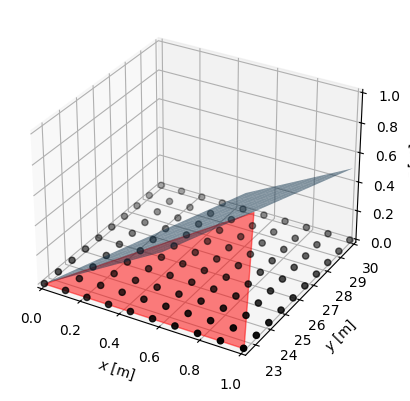

In [34]:
plt.ion()
ax = plt.axes(projection='3d')
ax.add_collection3d(Poly3DCollection([node_xyz[e_ijk]],alpha=0.5,color='red'))
ax.scatter(x3Dg,y3Dg,color='black')
ax.plot_surface(x3Dg.squeeze(),y3Dg.squeeze(),Nk,alpha=0.5,
                label=r"$N_k(x,y)$")
ax.set(xlim=(xmin_e,xmax_e),ylim=(ymin_e,ymax_e),zlim=(0.0,1.0))
ax.set(xlabel=r"$x$ [m]",ylabel=r"$y$ [m]",zlabel=r"$z$ [m]")
plt.show()
plt.ioff()

In order to compute the gradient of the displacement $\boldsymbol{\nabla}_\mathbf{x}\otimes\mathbf{\hat{u}}$. Recalling that

$$\hat{u}_m(x,y,t)\approx \hat{u}_{m,h}(x,y,t)=\mathbf{N}(\mathbf{x}_h(\boldsymbol{\xi}))^T.\mathbf{\hat{U}}_m(t)$$

one can compute the gradient as:

$$\boldsymbol{\nabla}_\mathbf{x}\otimes\mathbf{\hat{u}}(x,y,t)=\begin{bmatrix} \frac{\partial \hat{u}_{h,x}}{\partial x} & \frac{\partial \hat{u}_{h,y}}{\partial x}  \\  \frac{\partial \hat{u}_{h,x}}{\partial y} & \frac{\partial \hat{u}_{h,y}}{\partial y}
\end{bmatrix}=\sum_{n=1}^{n_d}\mathbf{e}_n\otimes \frac{\partial\mathbf{\hat{u}}}{\partial x_n}=\sum_{m,n=1}^{n_d} \mathbf{e}_n\otimes\frac{\partial\hat{u}_m}{\partial x_n} \mathbf{e}_m=$$

$$=\sum_{m,n=1}^{n_d} \mathbf{e}_n\otimes\mathbf{e}_m\otimes \frac{\partial \mathbf{N}}{\partial x_n}.\mathbf{\hat{U}}_m = \sum_{m=1}^{n_d} \mathbb{B}_m.\mathbf{\hat{U}}_m = \begin{bmatrix} \mathbb{B}_x & \mathbb{B}_y \end{bmatrix}.\mathbf{\hat{U}}(t) = \mathbb{B}.\mathbf{\hat{U}}(t)$$

The partial derivative of gradient of the shape function vector reads:

$$\frac{\partial \mathbf{N}}{\partial x_n} = \frac{1}{L}\sum_{m=1}^{N_n^e}\frac{\partial L_m}{\partial x_n}\mathbf{e}_m =\frac{1}{L} \begin{bmatrix} \frac{\partial L_i}{\partial x_n} \\  \frac{\partial L_j}{\partial x_n} \\\frac{\partial L_k}{\partial x_n}  \end{bmatrix}$$

According to the definition of the _area coordinates_, the gradient of $\mathbf{N}$ reads:

$$\frac{\partial \mathbf{N}}{\partial x_n}= \frac{1}{L}\sum_{i=1}^{N_n^e}\frac{\langle\mathbf{e}_n,(\mathbf{x}_j-\mathbf{x}_k)\wedge\mathbf{i}_z \rangle}{\langle \mathbf{x}_i-\mathbf{x}_k, (\mathbf{x}_j-\mathbf{x}_k)\wedge\mathbf{i}_z \rangle}\mathbf{e}_i$$

# TD / Hands-on session

### TODO: code the shape functions' gradient for CST elements

In [35]:
# Compute Shape function gradient
def ComputeShapeFunctionsGrad(x: np.float64,
                              node_xyz: list[list[int]],
                              e_ijk: list[int],
                              e_type="CST",
                              ndim=2) -> float:
    """
    Compute shape function gradient GradN for element with i,j,k nodes
    
        Parameters:
            
            x (np.array(dtype=np.float64)): array of coordinates (x,y,z)
            
            node_xyz (list(list(int))): list of nodal coordinates (x_i,x_j,x_k) 
                per each element e
                
            e_ijk (list(int)): global indices of (i,j,k) nodes for each element e
            
            e_type (str): type of elemnt (CST only available)
            
        Returns:
        
            GradN (dict): Matrix of gradients of shape functions defined as:
            
            GradN['x']= (1/L)*[∂L1/∂x,∂L2/∂x,∂L3/∂x] (column 'x' of GradN)
            GradN['y']= (1/L)*[∂L1/∂y,∂L2/∂y,∂L3/∂y] (column 'y' of GradN)
            GradN['z']= (1/L)*[∂L1/∂z,∂L2/∂z,∂L3/∂z]=0 (column 'z' of GradN)
    """
    GradN = {k:[] for k in ['x','y','z'][:ndim]} # Define gradN as dictionary over the dimensions
    
    if "CST" in e_type.upper():
        (x_i,x_j,x_k) = GetElemNodeCoord(node_xyz,e_ijk) # nodal coordinates
        L  = np.linalg.det(np.vstack((x_i-x_k, x_j-x_k, GetOrthoBase()['z']))) # 2*Area of the triangle
        for n in GradN.keys(): # Loop over directions x,y,z
            dLidxn = np.linalg.det(np.vstack((e_ijk, x_j-x_k, GetOrthoBase()['x']))) #TODO Area of triangle i
            dLjdxn = np.linalg.det(np.vstack((e_ijk, x_k-x_i, GetOrthoBase()['y']))) #TODO Area of triangle j
            dLkdxn = np.linalg.det(np.vstack((e_ijk, x_i-x_j, GetOrthoBase()['z']))) #TODO Area of triangle k
            dNdxn = np.array((dLidxn/L,dLjdxn/L,dLkdxn/L),dtype=np.float64)
            GradN[n] = dNdxn
    return GradN

In [36]:
# Assemble the gradient matrix Bm of the displacement field
def AssembleBm(dof: int,
               GradN: float,
               n_nodes: int,
               ndim=2) -> float:
    """
    Assemble Gradient matrix Bm of the displacement field
    
        Parameters:
        
            dof (int): direction of the gradient (dof=m) 
            
            GradN (dict): Matrix of gradients of shape functions defined as:
            
            GradN['x']= (1/L)*[∂L1/∂x,∂L2/∂x,∂L3/∂x]
            GradN['y']= (1/L)*[∂L1/∂y,∂L2/∂y,∂L3/∂y]
            ...
            
            n_nodes (int): total number of nodes
            
            ndim (int): dimension of the problem (Ω ⊂ R^ndim)
        
        Returns:
        
            Bm (np.float64): Assembled gradient matrix Bdof on the element
            
    """
    Bm = np.zeros((ndim,ndim,n_nodes)) # initialize the transpose gradient matrix
    
    em = GetOrthoBase()[dof][:ndim] # get the unit norm vector along the dof direction
    
    # Iterate over derivatives
    for n,dNdxn in GradN.items():
        en = GetOrthoBase()[n][:ndim]
        Bm += np.tensordot(np.tensordot(en,em,axes=0),dNdxn,axes=0)
    
    return Bm

The integrals are approximated by the Gauss quadrature rule:

$$\int_{\Omega_e} f(\mathbf{x}) dv = \int_{\Omega_{\triangle}} f(\boldsymbol{\xi}) J_e(\boldsymbol{\xi}) dv_{\triangle} \approx \sum_{g=1}^{N_{g}^e} f(\boldsymbol{\xi}_g) J_e(\boldsymbol{\xi}_g) w_g $$

In this case: 1 Gauss point = barycenter of the triangle

In [37]:
# Compute the Gauss point coordinates and weights of the linear transformation defined over the CST
def GetQuadrature(node_xyz: list[int],
                  e_ijk: list[int],
                  e_type='CST') -> tuple:
    """
    Dictionary of Gauss weights (CST only)
    
        Parameters:
        
            node_xyz (list(list(int))): list of nodal coordinates (x_i,x_j,x_k) 
                per each element e
            
            e_ijk (list(int)): global indices of (i,j,k) nodes for each element e
            
            e_type (str): type of elemnt (CST only available)
        
        Returns:
            weights (dict): dictionary of Gauss quadrature weights per element type
            wQ (list[float]): quadrature weights for the e_type
    """
    weights = {"CST":[1.]} # Quadrature weights dictionary
    wQ = weights[e_type]   # Quadrature weights for CST
    el_xQ = [np.vstack(GetElemNodeCoord(node_xyz,e_ijk)).sum(axis=0)/3.] # triangle baricenter
    return weights,wQ,el_xQ

### TODO Compute the Jacobian

In [38]:
# Compute the Jacobian of the linear transformation defined over the CST
def ComputeJacobian(node_xyz: list[list[float]],
                    e_ijk: list[list[int]],
                    ng=1,
                    e_type="CST",
                    ndim=2):
    """
    Compute the Jacobian of the diffeomorphism x_h = Σi Ni(x_h(ξ))C_xi
    at the Gauss point(s)
    
        Parameters:
            
            node_xyz (float): global list of nodal coordinates
            
            e_ijk (list(int)): global indices of (i,j,k) nodes for each element e
            
            ng (int): number of Gauss point(s) (only ng=1 available)
            
            e_type (str): type of elemnt (CST only available)
            
            ndim (int): dimension of the problem (Ω ⊂ R^ndim)
        
        Returns:
            
            Je (float): Jacobian of the element, evaluated at the Gauss point(s)            
    """
    if "CST" in e_type.upper():
        if ng==1:
            # baricentric or area coordinates [Mobius, 1827]
            (x_i,x_j,x_k) = GetElemNodeCoord(node_xyz,e_ijk) # nodal coordinates
            iz = GetOrthoBase()['z']
            Je = np.linalg.det(np.vstack((x_i-x_k, x_j-x_k, iz))) # TODO
            return [Je*0.5]

#### Assemble matrices

Recalling the equation of motion on one element $\Omega_e$:

$$\mathcal{M}(\mathbf{\ddot{\hat{u}}},\mathbf{w}) + \mathcal{K}(\mathbf{\hat{u}},\mathbf{w}) = \mathcal{F}(\mathbf{w})$$

and replacing the local approximation of $\mathbf{\hat{u}}\vert_{\bar{\Omega}_e}$, one obtains the following expression:

$$\mathcal{M}(\mathbb{N}.\mathbf{\ddot{\hat{U}}}(t),\mathbf{w}) + \mathcal{K}(\mathbb{N}.\mathbf{\hat{U}}(t),\mathbf{w}) = \mathcal{F}(\mathbf{w})$$

The Galerkin method adopts the same polynomial approximation for $\mathbf{w}\vert_{\bar\Omega_e}$:
 
 $$\mathcal{M}(\mathbb{N}.\mathbf{\ddot{\hat{U}}}(t),\mathbb{N}.\mathbf{W}) + \mathcal{K}(\mathbb{N}.\mathbf{\hat{U}}(t),\mathbb{N}.\mathbf{W}) = \mathcal{F}(\mathbb{N}.\mathbf{W})\qquad \forall \mathbf{w}\in\mathbb{V}_0(\bar\Omega_e)$$
 
 $$=\mathbf{W}^T\mathcal{M}(\mathbb{N}^T,\mathbb{N})\mathbf{\ddot{\hat{U}}}(t) + \mathbf{W}^T\mathcal{K}(\mathbb{N}^T,\mathbb{N})\mathbf{\hat{U}}(t) = \mathbf{W}^T\mathcal{F}(\mathbb{N}^T)\qquad \forall \mathbf{W}$$
 
Therefore, each (bi)linear form is associated to the following matrices/vectors:
 
 - Elemental mass matrix $\mathbb{M}_e = \mathcal{M}(\mathbb{N}^T,\mathbb{N})=\int_\Omega \rho \mathbb{N}^T.\mathbb{N}\text{ } dv$
 
 - Elemental stiffness matrix $\mathbb{K}_e = \mathcal{K}(\mathbb{N}^T,\mathbb{N})=\int_\Omega \mathbb{B}^T:\mathbb{D}_{el}:\mathbb{B}\text{ } dv$
 
 - Elemental external force vector: $\mathbf{F}_e=\mathcal{F}(\mathbb{N}^T)=\underbrace{\int_\Omega \mathbb{N}^T. \mathbf{f}_V(\mathbf{x},t) \text{ }dv}_{\text{volume forces}} -\underbrace{ \int_\Omega \rho \mathbb{N}^T. \mathbf{\ddot{u}}_G (\mathbf{x},t)\text{ }  dv}_{\text{inertial forces}} + \underbrace{\int_{\partial\Omega}\mathbb{N}^T.\mathbb{D}_{el}. \mathbb{B}.\mathbf{n}(\mathbf{x})\text{ } ds}_{\text{surface loading}}$
 
The equilibrium equation of the element, according to the Galerkin Finite Element method, can be written as:
 
$$\mathbb{M}_e.\mathbf{\ddot{\hat{U}}}_e(t)+\mathbb{K}_e.\mathbf{\hat{U}}_e(t)=\mathbf{F}_e$$

In [39]:
# Initialize matrices M,K and external force vectors Fv, Fg, Fs, F
def InitMatrices(ndofs: int)->tuple:
    """
    Initialize the matrices on the mesh
    
        Parameters:
        
            ndofs (int): global number of dofs
            
        Returns:
        
            M (np.float64): mass matrix (zeroes)
            
            K (np.float64): stiffness matrix (zeroes)
            
            Fv (np.float64): volume force vector (zeroes)
            
            Fg (np.float64): intertial force vector (zeroes)
            
            Fs (np.float64): surface force vector (zeroes)
            
            F (np.float64): total external force vector (zeroes)
    """
    M = np.zeros((ndofs,ndofs),dtype=np.float64) # Mass matrix
    K = np.zeros((ndofs,ndofs),dtype=np.float64) # Stiffness matrix
    Fv = np.zeros((ndofs,),dtype=np.float64) # Volume forces
    Fg = np.zeros((ndofs,),dtype=np.float64) # Inertial forces
    Fs = np.zeros((ndofs,),dtype=np.float64) # Surface forces
    F  = np.zeros((ndofs,),dtype=np.float64) # Totale forces
    return M,K,Fv,Fg,Fs,F

In [40]:
# Assemble dynamic system Mü + Ku = F
def AssembleDynamicSystem(ρ: float, 
                          ν: float, 
                          E: float,
                          ndim: int, 
                          mesh,
                          style="xxyyzz") -> tuple:
    """
    Assemble dynamic system Mü + Ku = F
    
        Parameters:
    
            ρ (float): unit-mass density [kg/m³]
        
            ν (float): Poisson's ratio [1]
        
            E (float): Young's modulus [Pa]
        
            ndim (int): dimension of the problem (Ω ⊂ R^ndim)
            
            mesh (pyvista): mesh of the domain
            
            style (str): two options are available:
                1. style="xxyy" ("xxyyzz") : 
                    [u_(1,x),u_(2,x),...,u_(n_nodes,x),u_(1,y),u_(2,y),...,u_(n_nodes,y)]
                
                2. style="xyxy" ("xyzxyz") : 
                    [u_(1,x),u_(1,y),u_(2,x),u_(2,y),...,u_(n_nodes,x),u_(n_nodes,y)] 
        
        Returns:
            
            M (np.float64): mass matrix (assembled)
            
            K (np.float64): stiffness matrix (assembled)
            
            Fv (np.float64): volume force vector (assembled)
            
            Fg (np.float64): intertial force vector (assembled)
            
            Fs (np.float64): surface force vector (assembled)
            
            F (np.float64): total external force vector (assembled)
    
    """
    # Mesh nodes
    n_nodes = mesh.n_points # number of nodes on the mesh
    ndofs = ndim*n_nodes # number of degrees of freedom
    node_xyz = mesh.points.astype(np.float64) # np.array
    # Cell tags (from gmsh)
    # 3: 2D lines
    # 5: 2D triangles
    cell_tag = {3:"LIN",5:"CST"}
    cell_physical_labels = {cell_tag[k]:v for k,v in mesh.cells_dict.items()}
    
    # pg = mesh.cell_arrays["gmsh:physical"] # get physical surface (the mesh of Ω domain)
    pg = mesh.cell_data["gmsh:physical"]  # get physical surface (the mesh of Ω domain)

    connectivity_dict = {}
    c = 0
    for k,v in mesh.cells_dict.items():
        connectivity_dict[cell_tag[k]] = [[e,pg[e]] for e in range(c,c+v.shape[0])]
        c += v.shape[0]
    
    # Get Lame parameters to construct Del
    LamePar = GetLamePar(ρ,ν,E,cell_physical_labels)
    
    # Initialize the matrices to zeroes
    M,K,Fv,Fg,Fs,F = InitMatrices(ndofs)
    
    # Loop over elements
    for e,e_ijk in enumerate(cell_physical_labels["CST"]):

        # Global element dof dictionary
        el_dofs = {'x':np.ix_([ScatterNode2Dof(n,'x',n_nodes,ndim=ndim,style=style)for n in e_ijk]),
                   'y':np.ix_([ScatterNode2Dof(n,'y',n_nodes,ndim=ndim,style=style)for n in e_ijk]),
                   'xx':np.ix_([ScatterNode2Dof(n,'x',n_nodes,ndim=ndim,style=style)for n in e_ijk],
                               [ScatterNode2Dof(n,'x',n_nodes,ndim=ndim,style=style)for n in e_ijk]),
                   'xy':np.ix_([ScatterNode2Dof(n,'x',n_nodes,ndim=ndim,style=style)for n in e_ijk],
                               [ScatterNode2Dof(n,'y',n_nodes,ndim=ndim,style=style)for n in e_ijk]),
                   'yx':np.ix_([ScatterNode2Dof(n,'y',n_nodes,ndim=ndim,style=style)for n in e_ijk],
                               [ScatterNode2Dof(n,'x',n_nodes,ndim=ndim,style=style)for n in e_ijk]),
                   'yy':np.ix_([ScatterNode2Dof(n,'y',n_nodes,ndim=ndim,style=style)for n in e_ijk],
                               [ScatterNode2Dof(n,'y',n_nodes,ndim=ndim,style=style)for n in e_ijk])}

        # quadrature point(s) coordinates
        _,wQ,el_xQ = GetQuadrature(node_xyz,e_ijk,e_type="CST")
        
        # Jacobian value(s) at quadrature point(s) ng
        el_JQ = ComputeJacobian(node_xyz,e_ijk,ng=len(el_xQ),e_type="CST",ndim=ndim)

        # Assemble the elemental Del at quadrature point(s)
        # In this case: homogeneous isotropic linear elastic elements
        I2,I2oI2,I4 = GetIdentityTensors(ndim)
        Del = LamePar['λ'][e] * I2oI2 + 2.*LamePar['μ'][e] * I4
        
        for q,xQ in enumerate(el_xQ): # loop over Quadrature points

            # Evaluate shape functions at quadrature point(s)
            # In this case: the barycenter of the CST
            # Ni(xQ) = Nj(xQ) = Nk(xQ) = 1/3
            N_xQ = ComputeShapeFunctions(xQ,node_xyz,e_ijk,e_type="CST",ndim=ndim) 

            # Evaluate function gradient at quadrature point(s)
            GradN_xQ = ComputeShapeFunctionsGrad(xQ,node_xyz,e_ijk,e_type="CST",ndim=ndim)

            # Loop over the gradient direction 
            # In this case x,y
            for m,vu in GradN_xQ.items():
                # print("first loop",m,vu)
                # Assemble elemental mass matrix at quadrature point(s)
                Me = LamePar['ρ'][e] * np.tensordot(N_xQ,N_xQ,axes = 0) * wQ[q] * el_JQ[q]
                # Lump matrix on the diagonal
                Me = np.diag(Me.sum(axis=1))
                # Cast into global mass matrix
                M[el_dofs[m+m]] += Me
                
                # Assemble and cast gravity force vector at quadrature point(s)
                Fv[el_dofs[m]] += LamePar['ρ'][e] * fv[m] * N_xQ * wQ[q] * el_JQ[q]

                # Assembly elemental inertial forces
                Fge = -np.ones((len(e_ijk),))*nG[m]
                # Cast into global inertial force vector
                Fg[el_dofs[m]] += Me@Fge

                # Assemble transposed gradient for U_u (u=x,y) at quadrature point(s)
                Bm_xQ = AssembleBm(m,GradN_xQ,len(e_ijk),ndim=ndim)
                # print(Bm_xQ)
                # print('---')
                # Assemble element stress field at quadrature point(s)
                # DelBm_xQ = np.einsum('ijkl,klm->ijm',Del,Bm_xQ)
                DelBm_xQ = np.tensordot(Del,Bm_xQ,axes=2)
                for n,vv in GradN_xQ.items():
                    # print("second loop",n,vv)
                    # Assemble Bm
                    Bn_xQ = AssembleBm(n,GradN_xQ,len(e_ijk),ndim=ndim)

                    # Assemble stiffness matrix
                    # Ke = np.einsum('nij,ijm->nm',Bn_xQ.T,DelBm_xQ) * wQ[q] * el_JQ[q]
                    Ke = np.tensordot(Bn_xQ.T,DelBm_xQ,axes=2)
                    K[el_dofs[n+m]] += Ke
                    # print(el_dofs[n+m],Ke)
                    # # plt.ion()
                    # fig, ax = plt.subplots(2)
                    # im=ax[0].matshow(K,cmap=coolwarm)
                    # fig.colorbar(im)
                    # im=ax[1].matshow(Ke,cmap=coolwarm)
                    # fig.colorbar(im)
                    # plt.show()
                    # # plt.ioff()

                    # print(el_dofs[n+m], n, m)
    return M,K,Fv,Fg,Fs,F

### TODO Assemble the system according to the two styles and compare Mass and Stiffness matrices

In [41]:
mesh = pv.read('DamMesh.msh')
Mxxyy,Kxxyy,Fvxxyy,Fgxxyy,Fsxxyy,Fxxyy = AssembleDynamicSystem(ρ, ν, E, ndim, mesh, "xxyy") # TODO
Mxyxy,Kxyxy,Fvxyxy,Fgxyxy,Fsxyxy,Fxyxy = AssembleDynamicSystem(ρ, ν, E, ndim, mesh, "xyxy") # TODO

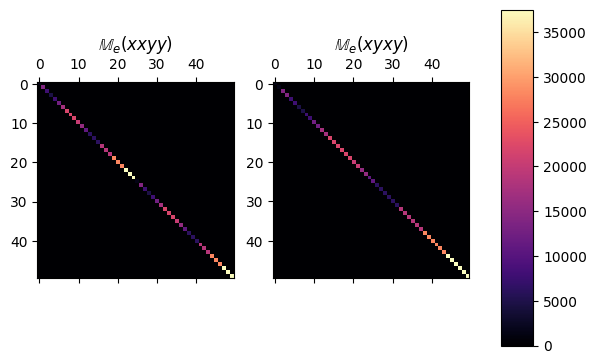

In [42]:
plt.ion()
fig, ax = plt.subplots(1,2,sharex=True)
im0=ax[0].matshow(Mxxyy,cmap=magma)
ax[0].set(title=r"$\mathbb{M}_e (xxyy)$")
im1=ax[1].matshow(Mxyxy,cmap=magma)
ax[1].set(title=r"$\mathbb{M}_e (xyxy)$")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im1, cax=cbar_ax)

plt.ioff()

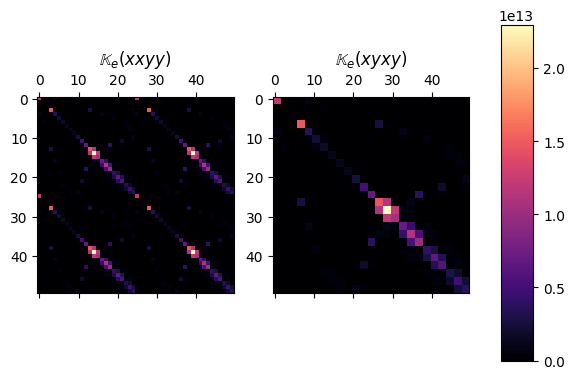

In [43]:
plt.ion()
fig, ax = plt.subplots(1,2,sharex=True)
im0=ax[0].matshow(Kxxyy,cmap=magma)
ax[0].set(title=r"$\mathbb{K}_e (xxyy)$")
im1=ax[1].matshow(Kxyxy,cmap=magma)
ax[1].set(title=r"$\mathbb{K}_e (xyxy)$")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im1, cax=cbar_ax)

plt.ioff()

Choose your style

In [44]:
mesh = pv.read('DamMesh.msh')
STYLE="xyxyzz"
M,K,Fv,Fg,Fs,F= AssembleDynamicSystem(ρ, ν, E, ndim, mesh, STYLE) # TODO

Assign boundary conditions and modify matrices accordingly:

In [45]:
# Assign boundary conditions and remove DOFs accordingly
def AssignBCDynamicSystem(M: float, 
                          K: float, 
                          Fv: float,
                          Fg: float,
                          Fs: float,
                          F: float,
                          mesh,
                          style="xxyyzz") -> tuple:
    """
    Remove DOFs according to boundary conditions
    
        Parameters:
    
            M (np.float64): mass matrix (assembled)
            
            K (np.float64): stiffness matrix (assembled)
            
            Fv (np.float64): volume force vector (assembled)
            
            Fg (np.float64): intertial force vector (assembled)
            
            Fs (np.float64): surface force vector (assembled)
            
            F (np.float64): total external force vector (assembled)
            
            mesh (pyvista): mesh of the domain
            
            style (str): two options are available:
                1. style="xxyy" ("xxyyzz") : 
                    [u_(1,x),u_(2,x),...,u_(n_nodes,x),u_(1,y),u_(2,y),...,u_(n_nodes,y)]
                
                2. style="xyxy" ("xyzxyz") : 
                    [u_(1,x),u_(1,y),u_(2,x),u_(2,y),...,u_(n_nodes,x),u_(n_nodes,y)]
        
        Returns:
            
            M (np.float64): mass matrix (assembled)
            
            K (np.float64): stiffness matrix (assembled)
            
            Fv (np.float64): volume force vector (assembled)
            
            Fg (np.float64): intertial force vector (assembled)
            
            Fs (np.float64): surface force vector (assembled)
            
            F (np.float64): total external force vector (assembled)
    
    """
    # Mesh nodes
    n_nodes = mesh.n_points # number of nodes on the mesh
    ndofs = ndim*n_nodes # number of degrees of freedom
    node_xyz = mesh.points.astype(np.float64) # np.array
    # Cell tags (from gmsh)
    # 3: 2D lines
    # 5: 2D triangles
    cell_tag = {3:"LIN",5:"CST"}
    cell_physical_labels = {cell_tag[k]:v for k,v in mesh.cells_dict.items()}
    
    # pg = mesh.cell_arrays["gmsh:physical"] # get physical surface (the mesh of Ω domain)
    pg = mesh.cell_data["gmsh:physical"]  # get physical surface (the mesh of Ω domain)

    connectivity_dict = {}
    c = 0
    for k,v in mesh.cells_dict.items():
        connectivity_dict[cell_tag[k]] = [[e,pg[e]] for e in range(c,c+v.shape[0])]
        c += v.shape[0]
        
    # Initialize the matrices to zeroes
    newM  = M.copy() 
    newK  = K.copy() 
    newFv = Fv.copy()
    newFg = Fg.copy()
    newFs = Fs.copy()
    newF  = F.copy() 
    
    # Dirichlet boundary conditions (clamping) on BC (label 200 in gmsh) 
    for tag in cell_physical_labels["LIN"]:
        if tag[1]==200:
            e_ij = elements["LIN"][tag[0]]

            dofs2pop = [ScatterNode2Dof(n,'x',n_nodes,ndim=ndim,style=style)for n in e_ij]+\
                       [ScatterNode2Dof(n,'y',n_nodes,ndim=ndim,style=style)for n in e_ij]

            newK  = np.delete(newK,dofs2pop,axis=1) # pop columns
            newK  = np.delete(newK,dofs2pop,axis=0) # pop rows corresponding to Dirichlet boundary condition
            newM  = np.delete(newM,dofs2pop,axis=1) # pop columns
            newM  = np.delete(newM,dofs2pop,axis=0) # pop rows corresponding to Dirichlet boundary condition
            newFv = np.delete(newFv,dofs2pop,axis=0) # pop rows corresponding to Dirichlet boundary condition
            newFg = np.delete(newFg,dofs2pop,axis=0) # pop rows corresponding to Dirichlet boundary condition
            newFs = np.delete(newFs,dofs2pop,axis=0) # pop rows corresponding to Dirichlet boundary condition
            newF  = np.delete(newF ,dofs2pop,axis=0) # pop rows corresponding to Dirichlet boundary condition
    M  = newM.copy() 
    K  = newK.copy() 
    Fv = newFv.copy()
    Fg = newFg.copy()
    Fs = newFs.copy()
    F  = newF.copy() 
    return M,K,Fv,Fg,Fs,F

In [46]:
STYLE="xyxyzz"
M,K,Fv,Fg,Fs,F = AssignBCDynamicSystem(M,K,Fv,Fg,Fs,F,mesh,style=STYLE)
ndofs = K.shape[1]
print(mesh)

UnstructuredGrid (0x7f84163c3c40)
  N Cells:    48
  N Points:   25
  X Bounds:   0.000e+00, 1.000e+01
  Y Bounds:   0.000e+00, 3.000e+01
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   3


#### Time Marching solver (Newmark)

<img src="Newmark_scheme.png">

<img src="HHT_scheme.png">

In [47]:
# Newmark's coefficients
New = {'alpha': 0.00, 'beta': 0.25, 'gamma': 0.5}
HHT = {'alpha': 0.01}
HHT['beta'] = (1.+HHT['alpha'])**2/4.
HHT['gamma'] = 0.5+HHT['alpha']

# time step 
dt = 0.001 # s
nt = 1000

scheme = "ND" # X=Un+1
coeff = New

### TODO: assemble the matrix $\mathbf{A}$ and $\mathbf{B}$

In [48]:
def AssembleA(scheme,coeff,dt,M,K):
    """
        Assembling A matrix based on different Newmark coeffs
    """
    (alpha,beta,gamma) = (coeff['alpha'],coeff['beta'],coeff['gamma'])
    
    Mtilde = (M+beta*dt**2*(1.-alpha)*K)
    
    if scheme == "ND":
        # Displacement-based
        A = (M+(beta*dt**2)*K)/(beta*dt**2) # TODO
    elif scheme == "NV":
        # Velocity-based
        A = (M+(beta*dt**2)*K)/(gamma*dt) # TODO
    elif scheme == "NA":
        # Acceleration-based
        A = M+(beta*dt**2)*K
    elif scheme == "HHT":
        # HHT
        A = Mtilde/(beta*dt**2)
    return A 

def AssembleB(scheme,coeff,dt,M,K,Fn,Fn1,pUn,pVn,Un=None):
    """
        Assembling B vector (RHS) based on different Newmark coeffs
    """
    (alpha,beta,gamma) = (coeff['alpha'],coeff['beta'],coeff['gamma'])
    
    Fn12 = (1.-alpha)*Fn1+alpha*Fn
    
    if scheme == "ND":
        # Displacement-based
        B = Fn1+(1/(beta*dt**2))*M@pUn # TODO
    elif scheme == "NV":
        # Velocity-based
        B = Fn1-K@pUn+(1/(gamma*dt))*M@pVn # TODO
    elif scheme == "NA":
        # Acceleration-based
        B = F1n-K@pUn # TODO
    elif scheme == "HHT":
        # HHT
        B = Fn12 + (1/(beta*dt**2))*M@pUn - alpha*K@Un # TODO
    
    return B

### TODO Compute Newmark correctors

In [49]:
# Newmark coeff predictor
def NewmarkPredictor(coeff,dt,Un,Vn,An):
    """
        Compute Newmark's prediction
    """
    (beta,gamma) = (coeff['beta'],coeff['gamma'])
    
    # Displacement prediction
    pUn = Un + dt*Vn + (0.5-beta)*dt**2*An
    
    # Velocity prediction
    pVn = Vn + (1.-gamma)*dt*An 
    
    return pUn,pVn

# Newmark coeff Corrector
def NewmarkCorrector(scheme,coeff,dt,pUn,pVn,X):
    """
        Compute Newmark's correction based on solution of the system A.X = B
    """
    (beta,gamma) = (coeff['beta'],coeff['gamma'])
    
    if scheme == "ND": # X = Un1
        Un1 = X # Displacement correction
        An1 = (Un1 - pUn) / (beta * dt**2) # TODO: compute Acceleration correction
        Vn1 = pVn + gamma * dt * An1 # TODO: compute Velocity correction
    elif scheme == "NV":
        Vn1 = X # Velocity correction
        An1 = (Vn1 - pVn) / (gamma * dt) # TODO: compute Acceleration correction
        Un1 = pUn + beta * dt**2 * An1 # TODO: compute Displacement correction
    elif scheme == "NA":
        An1 = X # Acceleration correction 
        Un1 = pUn + beta * dt**2 * An1 # TODO: compute Displacement correction
        Vn1 = pVn + gamma * dt * An1 # TODO: compute Velocity correction
        
    return Un1,Vn1,An1

### TODO Implement the Conjugate gradient algorithm

In [50]:
def SolveCG(A, b, n, iteration_thresh, res_thresh):
    """Conjugate Gradient (CG).

    :references:
    Hestenes and Stiefel, 1952
    Magoules and Roux, 2013

    :parameter
    A : dense matrix
    b : vector
    n : number of rows of the matrix
    iteration_thresh : maximum number of iterations
    res_thresh : stopping ctiteria
    x : solution of the linear system
    iteration : number of iteration
    """

#     print('Iterations of sequential algorithm')
    sys.stdout.flush()

    # -- initialization of the conjugate gradient
    # initialize solution x
    x = np.zeros(n, dtype=A.dtype)

    # initialize gradient g
    g = -b.copy()

    # initialize vector w
    w = g.copy()

    # compute norm: sqrt( (g, g)
    res_init = np.linalg.norm(g) # TODO
    res_norm = res_init # TODO
    vec_res_rel = np.zeros(iteration_thresh) # TODO

    # -- iteration of the conjugate gradient
    iteration = 0
    while res_norm >= res_thresh and iteration < iteration_thresh:
        # matrix-vector product: v = A * w
        v = A.dot(w) # TODO

        # scalar product: s = (g, w)
        s1 = np.vdot(g, w) # TODO

        # scalar product: s = (v, w)
        s2 = np.vdot(v, w)

        # compute coefficient rho
        rho = - s1 /s2

        # compute relative residual
        vec_res_rel[iteration] = np.linalg.norm(rho * w)

        # update x
        x = x + rho * w # TODO

        # update g
        g = g + rho * v # TODO

        # scalar product: s = (g, v)
        s3 = np.vdot(g, v) # TODO

        # scalar product: s = (v, w)
        s4 = np.vdot(v, w) # TODO

        # compute coefficient gamma
        gamma = - s3 / s4

        # compute residual
        res_norm = np.linalg.norm(g) / res_init

        # update w
        w = g + gamma * w # TODO

        iteration = iteration + 1
#         print('CG parallel iter {:d} : res {:.3e}'.format(iteration, res_norm))

    return x, iteration

In [51]:
A = AssembleA(scheme,coeff,dt,M,K)

In [52]:
# Time marching evolution

Un=np.zeros((ndofs,),dtype=np.float64) # displacement vector at time step tn
Vn=np.zeros((ndofs,),dtype=np.float64) # velocity vector at time step tn
An=np.zeros((ndofs,),dtype=np.float64) # acceleration vector at time step tn

U=np.zeros((nt,ndofs,),dtype=np.float64) # displacement vector at time step tn
dU=np.zeros((nt,ndofs,),dtype=np.float64) # velocity vector at time step tn
ddU=np.zeros((nt,ndofs,),dtype=np.float64) # acceleration vector at time step tn

A = AssembleA(scheme,coeff,dt,M,K)

iteration_thresh = 100
res_thresh = 1E-6

for tn in range(nt):
    
    # Newmark's prediction
    pUn,pVn = NewmarkPredictor(coeff,dt,Un,Vn,An)
    
    # Assemble Fn and Fn+1
    Fn  = Fv+Fg*aG['x'](np.array([max(tn-1,0)*dt]))
    Fn1 = Fv+Fg*aG['x'](np.array([tn*dt]))
    # Assemble RHS
    b = AssembleB(scheme,coeff,dt,M,K,Fn,Fn1,pUn,pVn,Un)
    
    # Solve system A.X = B solve_conjugate_gradient [by Frédéric Magoules]
    X,_ = SolveCG(A,b,A.shape[0], iteration_thresh, res_thresh)
        
    # Newmark's correction
    Un,Vn,An = NewmarkCorrector(scheme,coeff,dt,pUn,pVn,X)

    U[tn]=Un
    dU[tn]=Vn
    ddU[tn]=An    

Display solution on the mesh

In [53]:
tn = 2
if STYLE=="xxyyzz":
    mesh["UnX"] = U[tn,:ndofs]
    mesh["UnY"] = U[tn,ndofs:]
else:
    mesh["UnX"] = U[tn,0::2]
    mesh["UnY"] = U[tn,1::2]

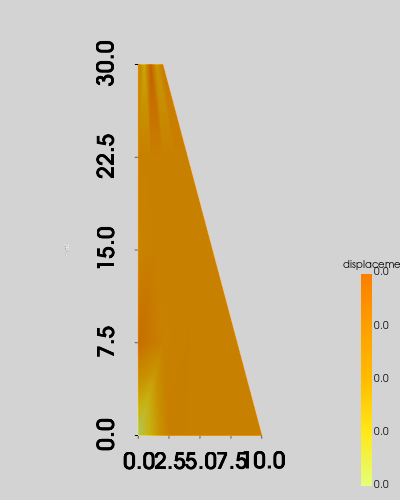

In [54]:
# Plot partitioned mesh element-wise
plotter = pv.Plotter()
plotter.show_bounds(xtitle="X [m]", ytitle="Y [m]", ticks="outside")
plotter.add_mesh(mesh,
                 scalars=mesh["UnX"],
                 component=0,
                 show_edges=False,
                 cmap="Wistia",
                 scalar_bar_args={'vertical': True, 
                                  # 'fmt': "%.1f",
                                  'title': "displacement",
                                  'title_font_size': 10,
                                  'label_font_size': 10,},
                 color="lightblue")
plotter.show(cpos="xy", interactive_update=True)